# COGS 108 - EDA Checkpoint

# Names

- Aleene Baeza
- George Gavrilov
- Karen Gong
- Vedan Desai
- Costin Smilovici

<a id='research_question'></a>
# Research Question

Does one US political party have a tendency to disproportionately use more negative sentiment on Twitter than the other and if so, what motivates this?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from requests_oauthlib import OAuth1Session
import json

plt.rcParams['figure.figsize'] = (17, 7)
plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format ='retina'
import warnings
warnings.filterwarnings('ignore')
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 
from nltk.tokenize import word_tokenize

# import stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import PorterStemmer

ps = PorterStemmer()

from nltk.probability import FreqDist
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vdand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vdand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vdand\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Data Cleaning

Describe your data cleaning steps here.

In [2]:
df = pd.read_csv('Data/cleaned_data.csv')

There's only one column we actually have to clean, namely convert the created_at column to Pandas timestamps:

In [3]:
df['created_at'].dtype

dtype('O')

In [4]:
df['created_at'] = pd.to_datetime(df['created_at'])

Other than this sole column, every other feature appears to be in a data type we can work with:

In [5]:
df.dtypes

text                          object
party_name                    object
created_at       datetime64[ns, UTC]
hashtags                      object
retweet_count                  int64
reply_count                    int64
like_count                     int64
quote_count                    int64
dtype: object

Next we'll check for nulls:

In [6]:
df.isna().sum().sum()

0

There are no Pandas or numpy nulls inside of this dataset so for now it should be good enough to explore. However if we do end up running into something unclean in the following cells we will return to this section.

# Data Analysis & Results (EDA)

Our research question revolves around political parties so it would suit our analysis to have an equal representation of both parties in the overall dataset. We will explore to determine if this is the case both visually and statistically:

In [54]:
# Generate proportions to understand how well-represented every party is in our dataset
df.value_counts(subset='party_name', normalize=True)

party_name
Democrat      0.624179
Republican    0.375821
dtype: float64

<AxesSubplot:xlabel='party_name', ylabel='0'>

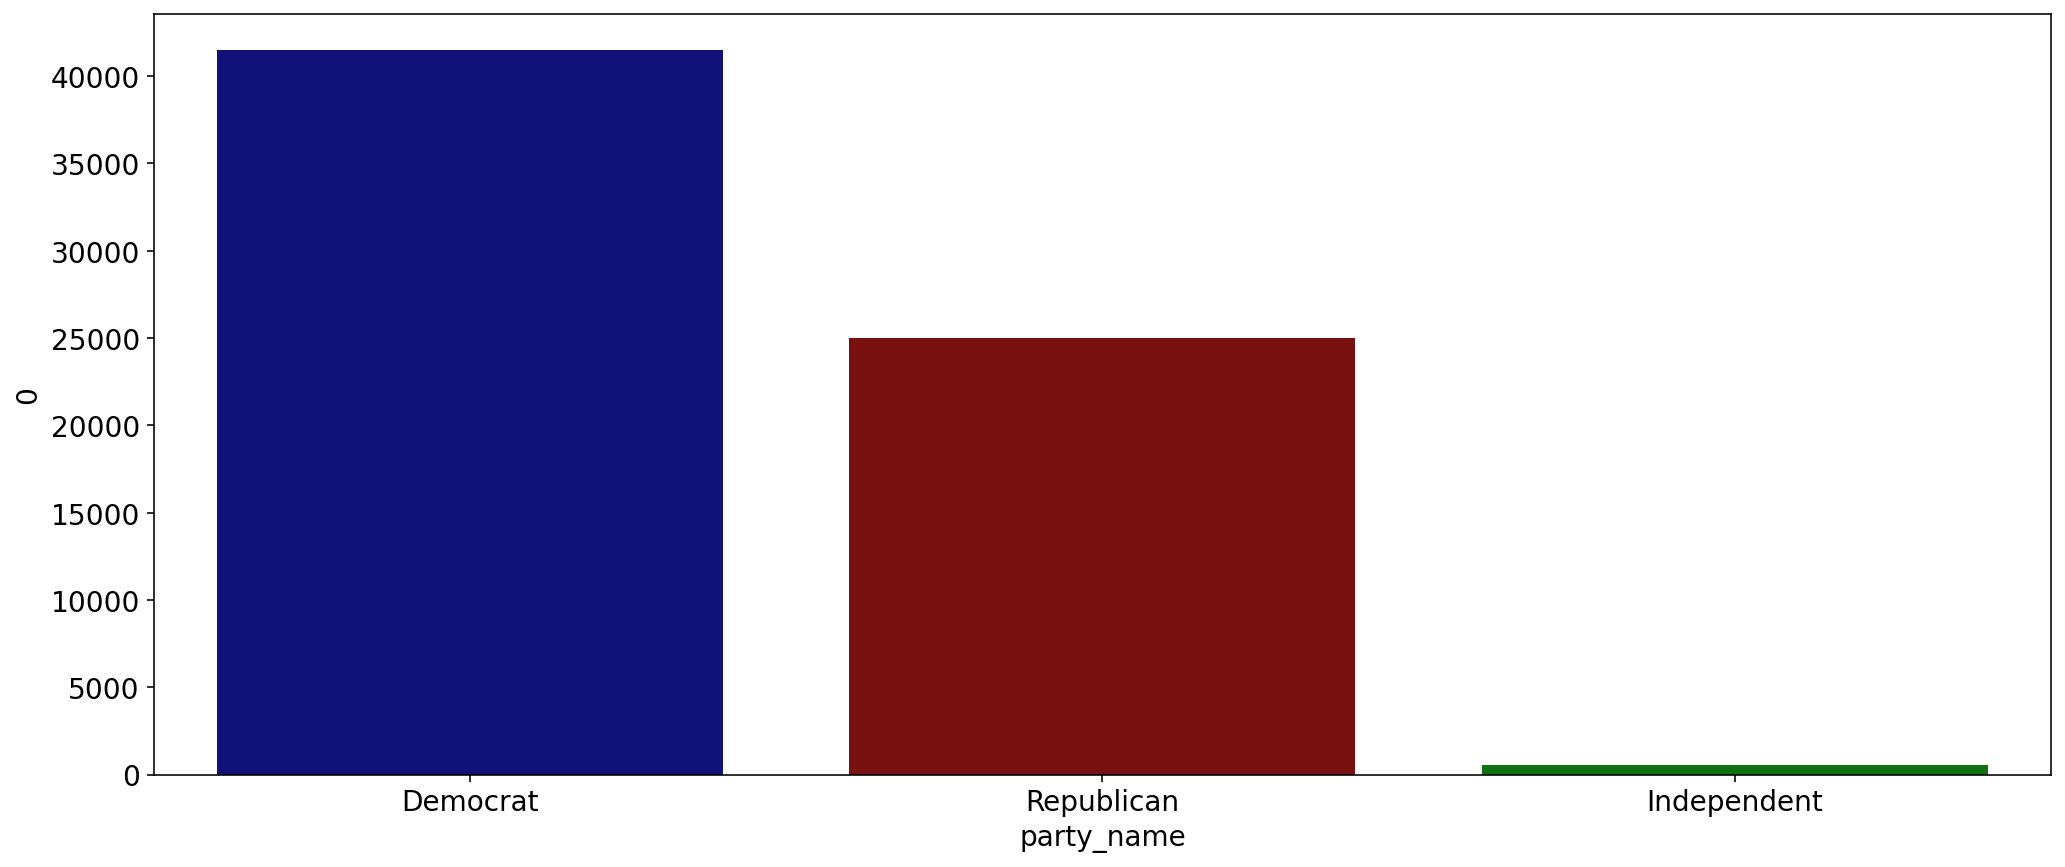

In [8]:
# Plot the result from the above cell
to_plot = pd.DataFrame(df.value_counts(subset='party_name'))
sns.barplot(x=to_plot.index, y=to_plot[0], palette=['darkblue', 'darkred', 'green'])

As the above cells demonstrate our dataset has a significantly higher proportion of Democrats than Republicans. Proportionally Democrats sit at 62%, Republicans sit at 37% and Independets sit at approximately 1% of the dataset. Thus we may have to resample within groups to create a more equal dataset that will allow us to draw more statistically powerful conclusions. In addition there are still independents in this dataset. For future use, it would be helpful to have a dataset without independents:

In [9]:
demsreps = df[df['party_name'] != 'Independent']

Another aspect of our analysis that we may eventually arrive at is whether or not politicians are being more negative and inciting in order to increase engagement. As such it would be helpful to conduct a quick exploration or study into what engagement looks like right now across the dataset using public metrics like retweets, replies, quotes, and the most ubiquitous metric, likes:

In [10]:
df.describe()

,retweet_count,reply_count,like_count,quote_count
count,67038.000000,67038.000000,67038.000000,67038.000000
mean,341.880232,44.614994,468.395880,11.357872
std,3520.990855,471.555483,4870.108487,136.088261
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,5.000000,1.000000,4.000000,0.000000
75%,25.000000,5.000000,27.000000,1.000000
max,329623.000000,31317.000000,587398.000000,17059.000000


The above description demonstrates an interesting fact about our data. While the measures of central tendency are relatively low, the measures of spread are rather high. Since none of these values will drop below 0, this indicates that the vast majority of tweets are actually spread relatively thin. For proof of this, the following boxplot that breaks down likes between parties demonstrates said relationship:

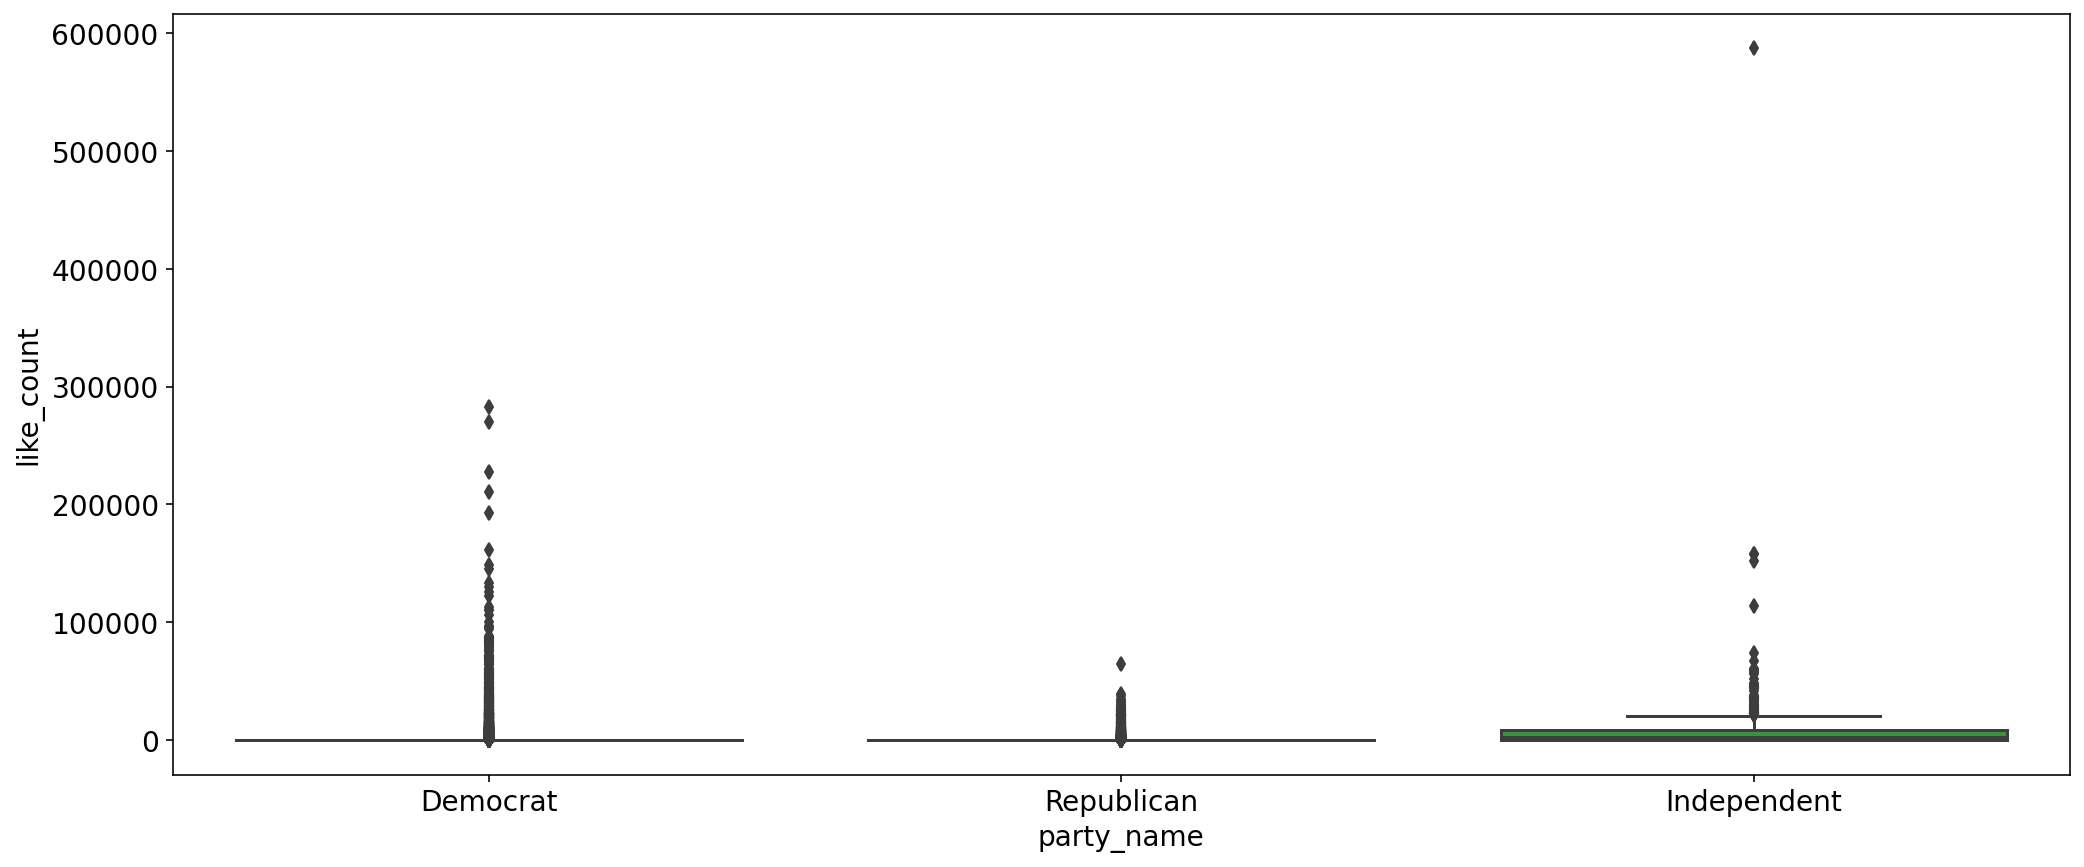

In [11]:
ax = sns.boxplot(x="party_name", y="like_count", data=df)

So as hypothesized from the .describe() earlier, the data appears to be skewed low, and except for some unique outliers, we have a relatively even game in terms of likes. We could investigate the outlier, but that really isn't the goal of the project. Since engagement appears to be relatively agnostic to party affiliation alone, let us now move in to investigating the relationships between three concepts: Sentiments, party affiliation, and engagement, since that is what the bulk of our project will be comprised of. In order to do that we will have to analyze the sentiment of the tweets within our dataset, and that work is done in the following cells:

In [12]:
# get list of the tweets from each observation
cleaned_list = list(df['text'].values)

VADER (Valence Aware Dictionary for Sentiment Reasoning) is a rather interesting model. It can be applied directly to unlabeled text data, and that text data does not necessarily have to be tokenized or otherwise cleaned - VADER is rather robust and is built to handle various punctuation, capitalization and even emojis, as mentioned in class. As such it's a rather plug and play model that we deploy using the below function:

In [13]:
# create function that will output dataframe 
# that stores sentiment information
def get_sentiments(input_list):
    
    output = pd.DataFrame()

    for sentence in input_list:
        ss = analyser.polarity_scores(sentence)
        ss['sentence'] = sentence
        output = output.append(ss, ignore_index=True)

    return output

In [14]:
sentiments = get_sentiments(cleaned_list)

In [15]:
sentiments.head(10)

,neg,neu,pos,compound,sentence
0,0.125,0.875,0.000,-0.2500,Garrett was 1 of just a handful of fringe extr...
1,0.143,0.729,0.128,-0.1280,"""No one fights harder than Josh to bring back ..."
2,0.043,0.911,0.047,0.0516,"""Two years in Washington is not much time, yet..."
3,0.074,0.817,0.109,0.2244,TODAY'S THE DAY! Stopped by the Hackensack Tra...
4,0.231,0.769,0.000,-0.4019,Bergen Congressman Reacts To 'Horrific' Shooti...
5,0.000,1.000,0.000,0.0000,"""[Garrett's] fanaticism is too much, even for ..."
6,0.142,0.647,0.211,0.6486,"""We're the proud home to world-class research ..."
7,0.000,1.000,0.000,0.0000,Today is National Voter Registration Day. Down...
8,0.000,0.594,0.406,0.8356,Glad to help these communities claw back feder...
9,0.000,0.734,0.266,0.7845,I believe all 4 counties deserve a Congressman...


Just to make sure it's working, let's find a highly positive and highly negative tweet and see if those seem positive/negative from our perspective:

In [16]:
#This line of code gets most negatively classified sentence
sentiments.sort_values(by='compound').iloc[0]['sentence']

"Starving a child is violence. \r\n\r\nPunishing a mother and her family is violence \r\n\r\nContempt for poverty is violence. \r\n\r\nThis administration's attacks on #SNAP would threaten benefits for more than 100000 ppl in Massachusetts which includes 72000 children. This is child abuse. Period. https://t.co/gBfVQZcYJf"

In [17]:
#This line of code gets most positively classified sentence
sentiments.sort_values(by='compound').iloc[-1]['sentence']

'“And love is love is love is love is love is love is love is love cannot be killed or swept aside” -- .@lin_manuel. Proud to have earned a 100 on .@HRC congressional scorecard for my support for the #LGBTQ community! https://t.co/wVxNtCmGuT'

So as the above two tweets demonstrate, VADER seems to be working as intended. Now that we are relatively certain that VADER is working, let's see what our derived sentiment data looks like:

In [18]:
sentiments.describe()

,neg,neu,pos,compound
count,67038.000000,67038.000000,67038.000000,67038.000000
mean,0.056502,0.799628,0.143869,0.223944
std,0.091035,0.145528,0.138426,0.488299
min,0.000000,0.088000,0.000000,-0.987100
25%,0.000000,0.702000,0.000000,0.000000
50%,0.000000,0.804000,0.126000,0.296000
75%,0.100000,0.902000,0.230000,0.648600
max,0.912000,1.000000,0.910000,0.992900


Interestingly the compound mean is slightly positive leaning, meaning that the bulk of our dataset are tweets classified as slightly positive by VADER. The maximum and minimum tweets are displayed in the above cells, but those are clearly outliers. Just to get a clearer visualization of the compound score, let's plot a histogram of the compound column alone:

<AxesSubplot:xlabel='compound', ylabel='Count'>

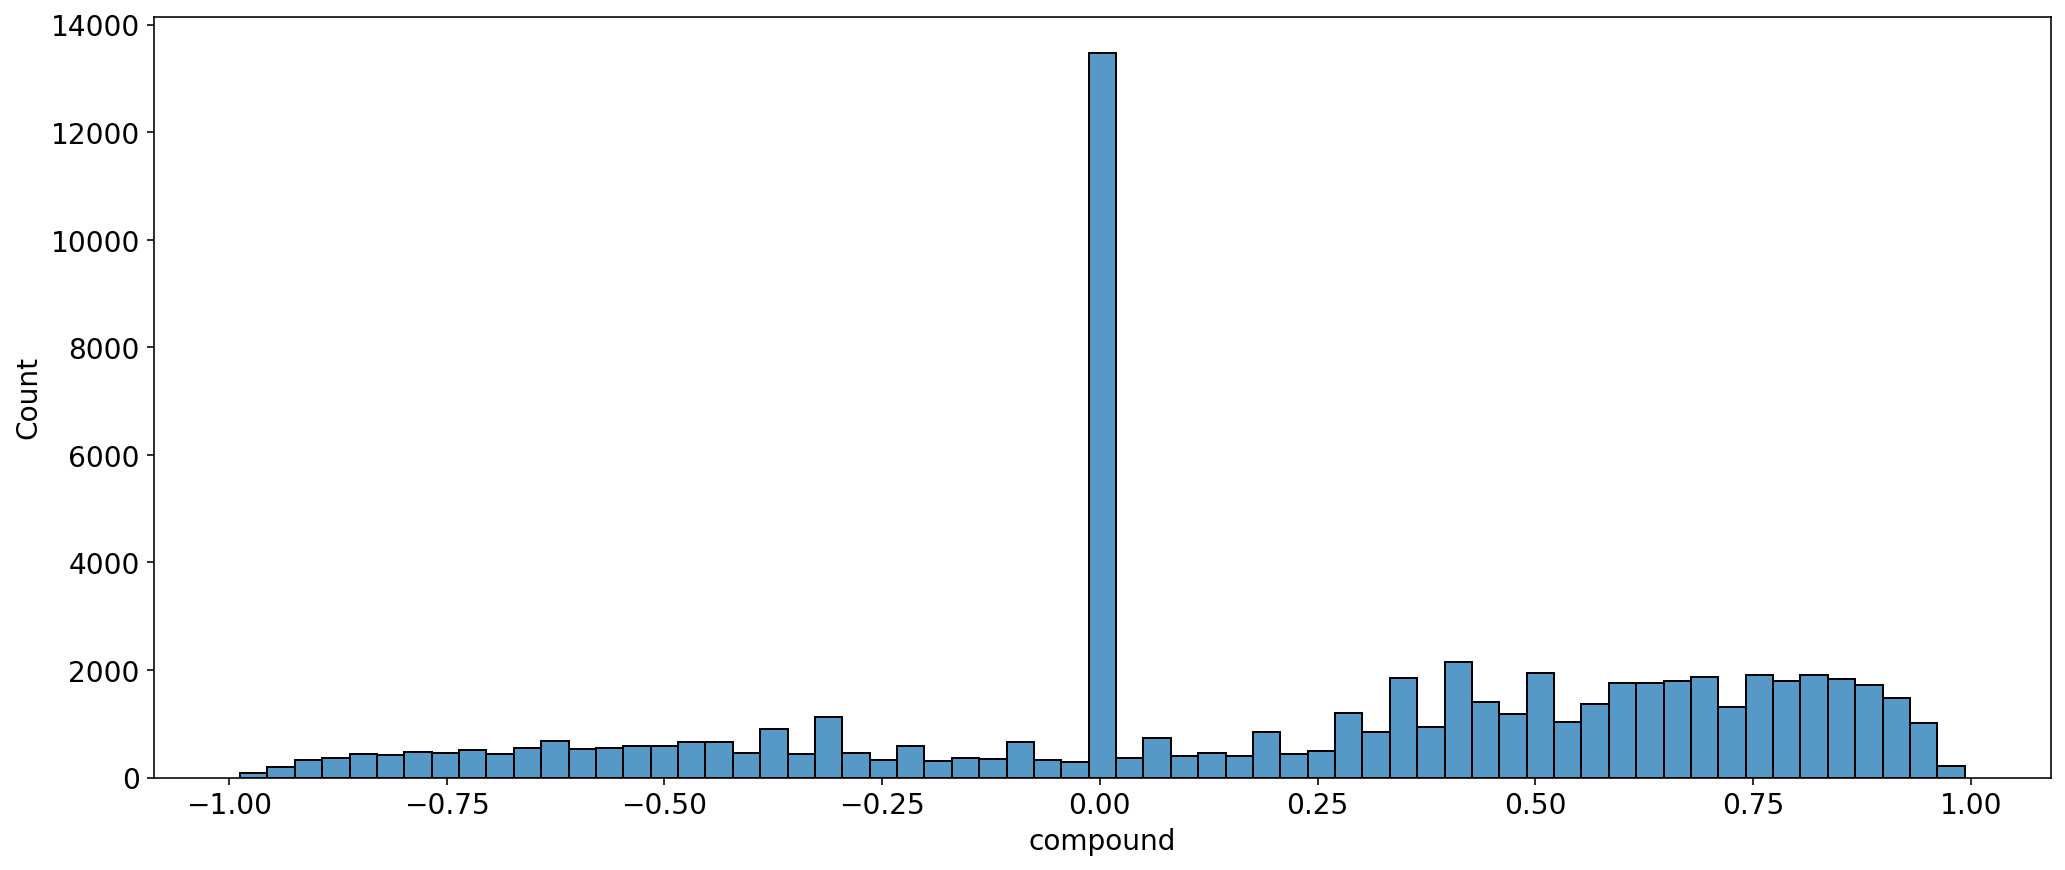

In [19]:
sns.histplot(x=sentiments['compound'])

So the vast majority of our dataset registers as completely neutral, with more observations classified as positive than negative. While this information alone reveals that political tweets are not as negative as we first thought, we still want to find the relationship, if there is any, between sentiment and political party, and perhaps on top of that, engagement. So in the following cell, we combine our sentiment dataframe with our party affiliation and raw tweets dataframe:

In [20]:
# Merges the two dataframes together using the 'text' and 'sentence' features while dropping the 'sentence' feature
df = pd.merge(demsreps, sentiments, left_on='text', right_on='sentence').drop(columns=['sentence'])

In [21]:
df.head()

,text,party_name,created_at,hashtags,retweet_count,reply_count,like_count,quote_count,neg,neu,pos,compound
0,Garrett was 1 of just a handful of fringe extr...,Democrat,2016-09-13 16:15:12+00:00,['VAWA'],4,0,5,0,0.125,0.875,0.000,-0.2500
1,"""No one fights harder than Josh to bring back ...",Democrat,2018-06-19 14:41:25+00:00,[],0,1,2,0,0.143,0.729,0.128,-0.1280
2,"""Two years in Washington is not much time, yet...",Democrat,2018-11-01 23:20:35+00:00,[],7,0,20,0,0.043,0.911,0.047,0.0516
3,TODAY'S THE DAY! Stopped by the Hackensack Tra...,Democrat,2018-11-06 16:20:00+00:00,['ElectionDay'],0,2,11,0,0.074,0.817,0.109,0.2244
4,Bergen Congressman Reacts To 'Horrific' Shooti...,Democrat,2017-06-15 19:26:50+00:00,[],1,0,3,0,0.231,0.769,0.000,-0.4019


So now that the two datasets above are combined into one let's not beat around the bush any longer; which party is currently more negative according to our sample?

<AxesSubplot:xlabel='party_name'>

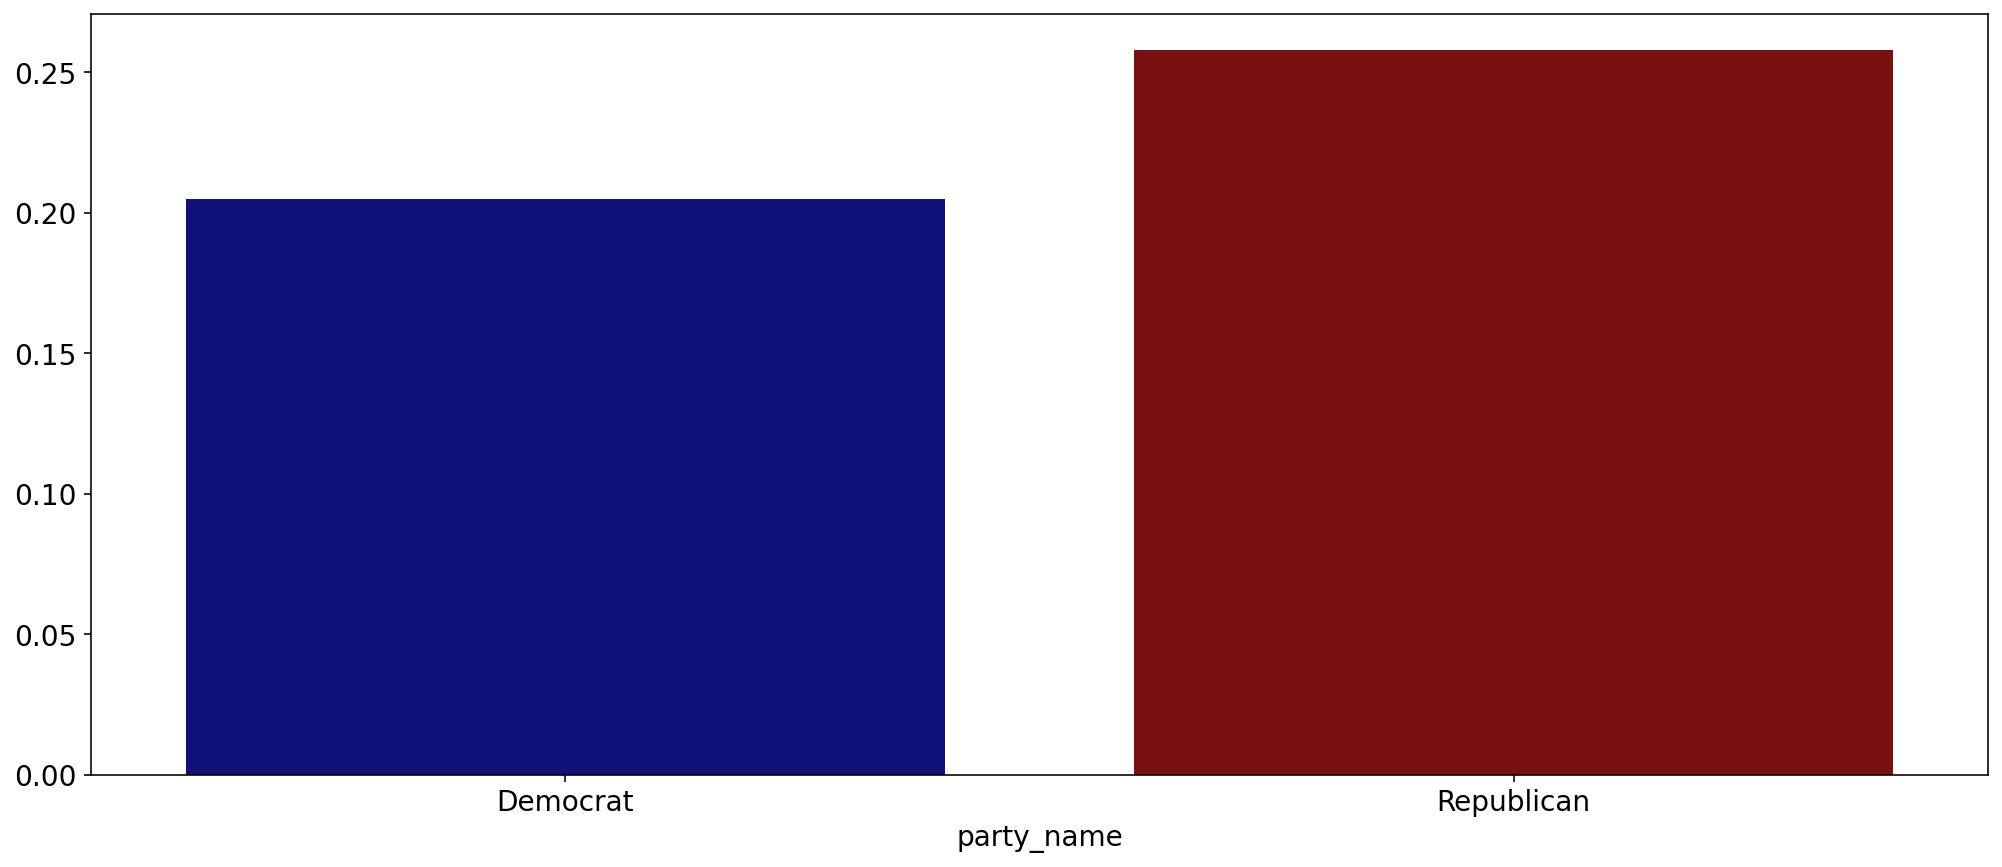

In [28]:
to_plot = df.groupby('party_name')['compound'].mean()
sns.barplot(x=to_plot.index, y=to_plot.values, palette=['darkblue', 'darkred'])

And immediately it becomes obvious that our hypothesis may be incorrect; in fact if VADER sentiment analysis is to be believed, our current dataset shows us that Republicans are in fact more positive on average in their tweets than Democrats. Let's take a look at only negative scores just to make sure this makes sense:

<AxesSubplot:xlabel='party_name'>

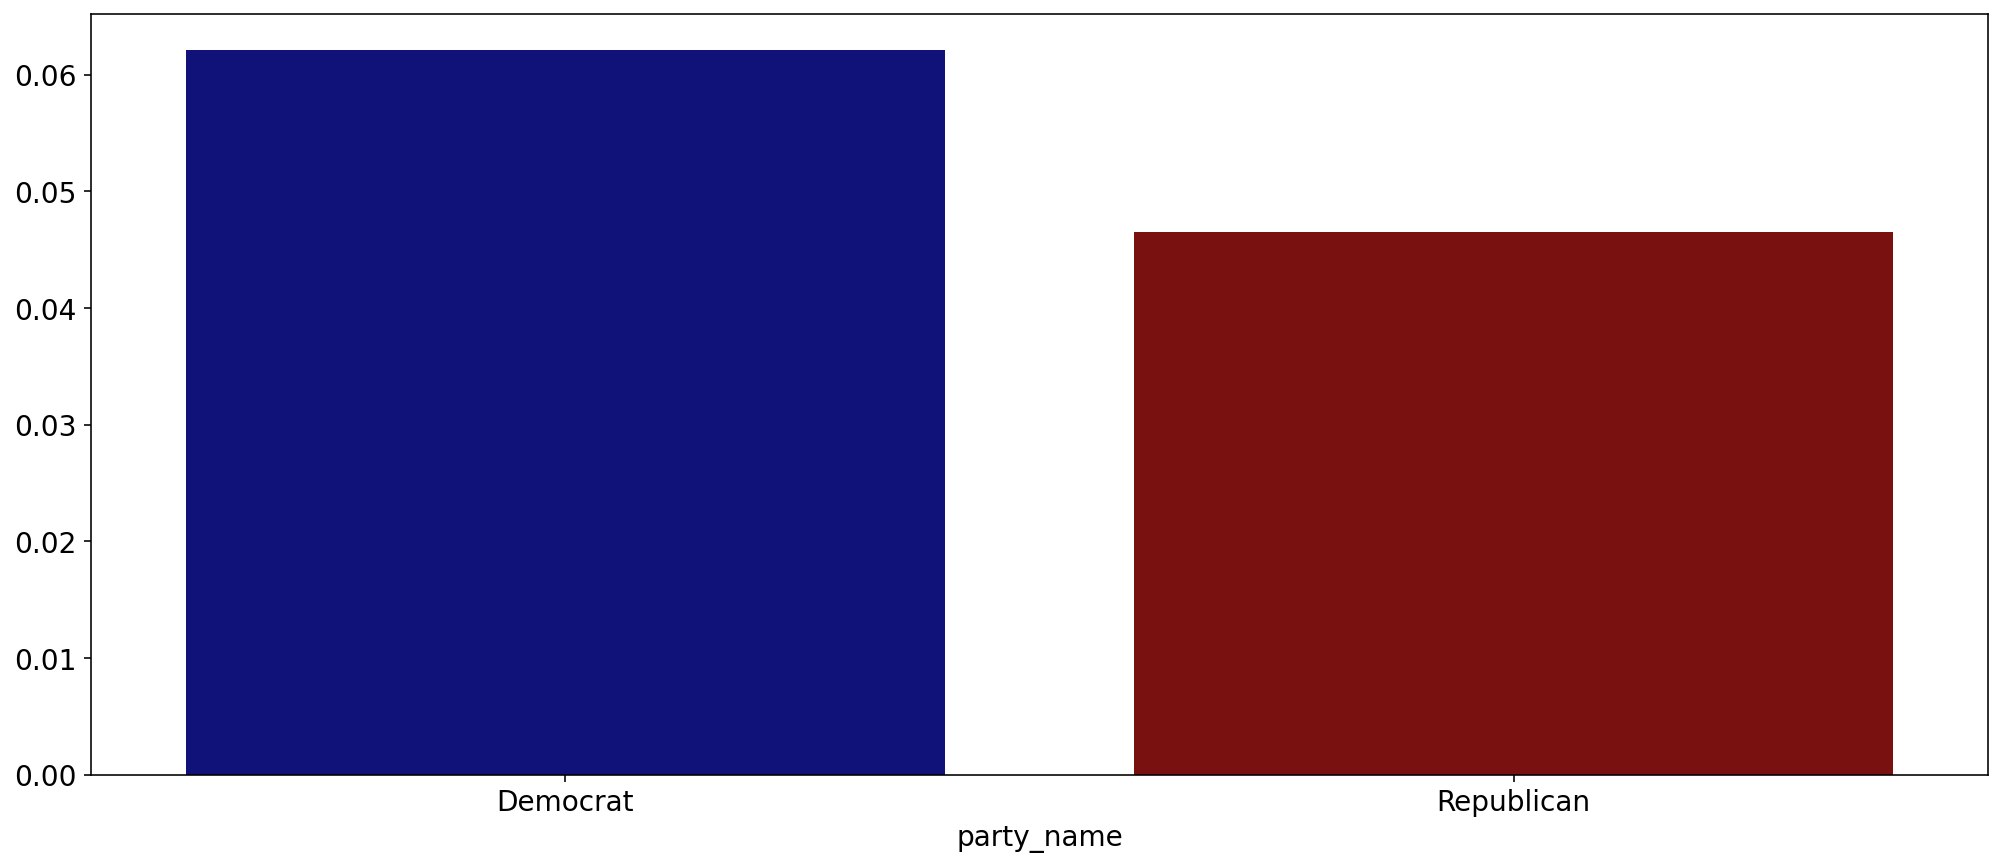

In [27]:
to_plot = df.groupby('party_name')['neg'].mean()
sns.barplot(x=to_plot.index, y=to_plot.values, palette=['darkblue', 'darkred'])

And again it is made clear that Republicans are less negative than Democrats. This makes sense once you consider that the compound score is calculated as the positive score + the negative score + the neutral score. There is yet another visualization we can create to check if perhaps Democrats just have one or two extremely negative tweets that are pulling them down but Republicans have more negative tweets overall. That visualization is a hued histogram as follows:

<AxesSubplot:xlabel='compound', ylabel='Count'>

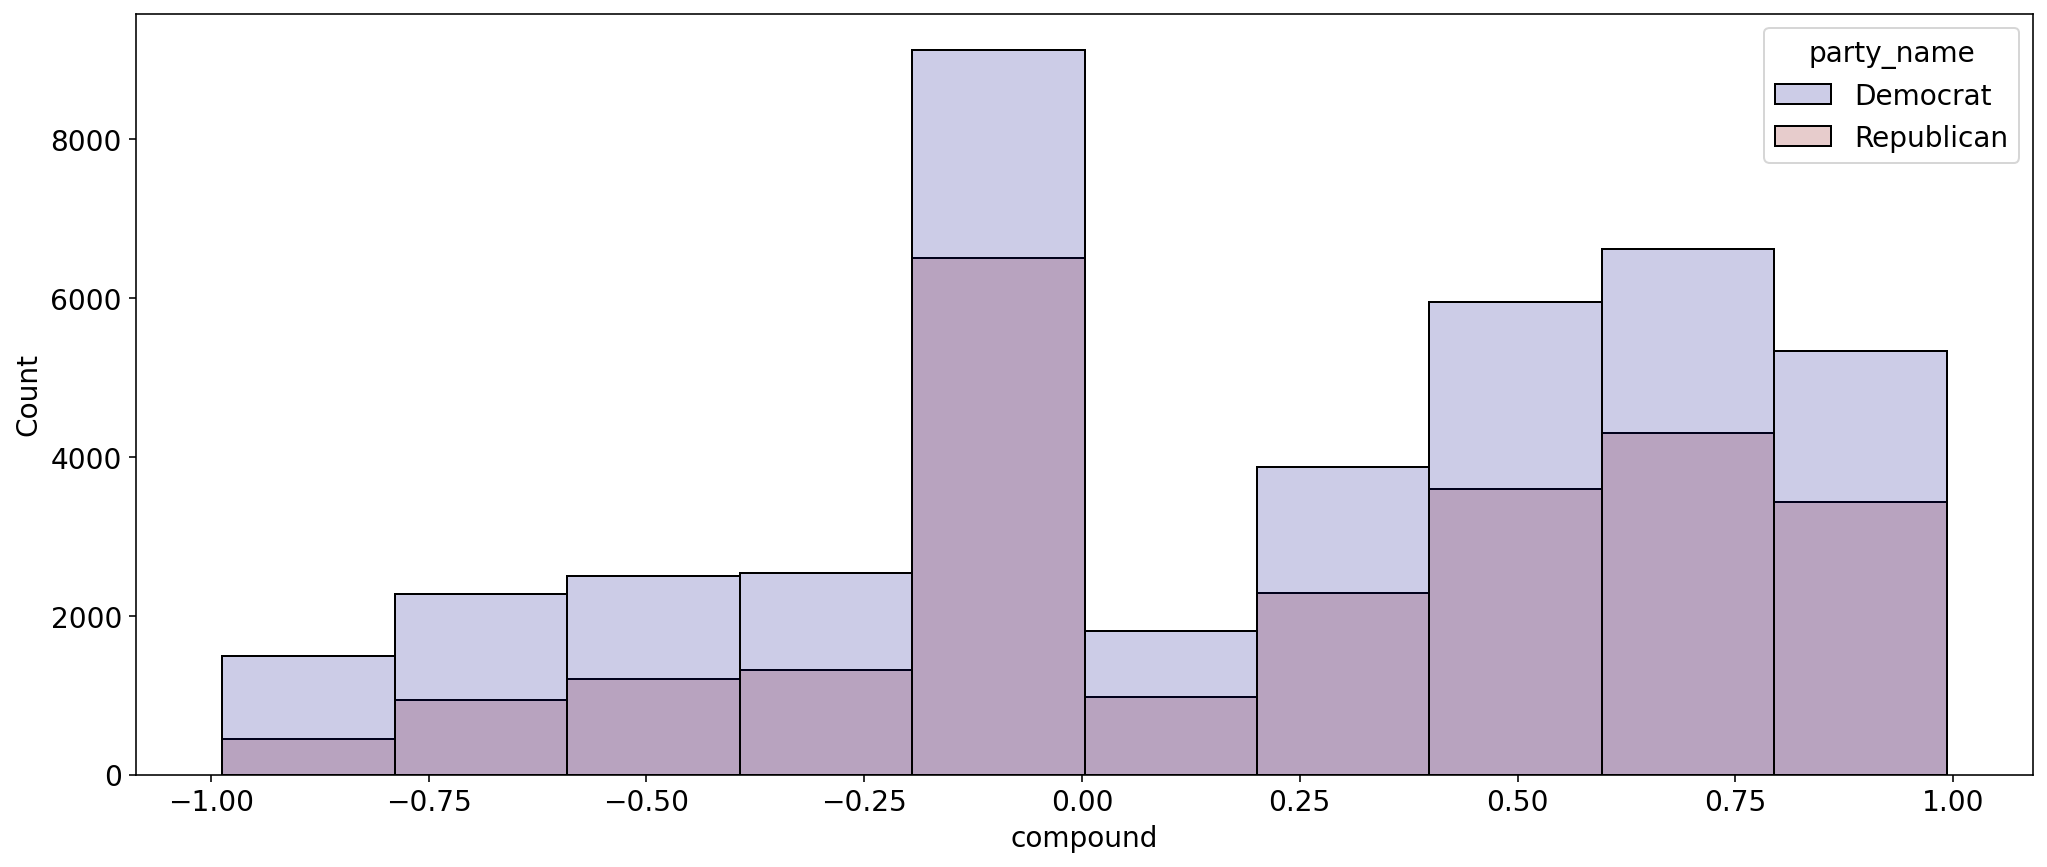

In [29]:
sns.histplot(data=df, x="compound", hue="party_name", palette=['darkblue', 'darkred'], bins=10, alpha=0.2)

So interestingly it appears that both of the parties share a similar distribution in terms of sentiment. So there is no statistically interesting reasoning for Democrats having more negative tweets than Republicans. They simply do, and thus our original hypothesis may be incorrect (although an actual hypothesis test will be conducted in the analysis section to ensure that this is indeed the case). But now that we have an understanding of which party, surprisingly, has more positive tweets on average, let us see if there is a relationship between sentiment and engagement. This is because a part of our question deals with understanding why a party is being more negative, if we can reasonably claim that they are with a hypothesis test. In the below cell, we plot the relationship between sentiment and engagement. What we expect to see is something resembling a line with positive slope. This is because we expect tweets classified as high in sentiment to have more engagement:

<AxesSubplot:xlabel='compound', ylabel='like_count'>

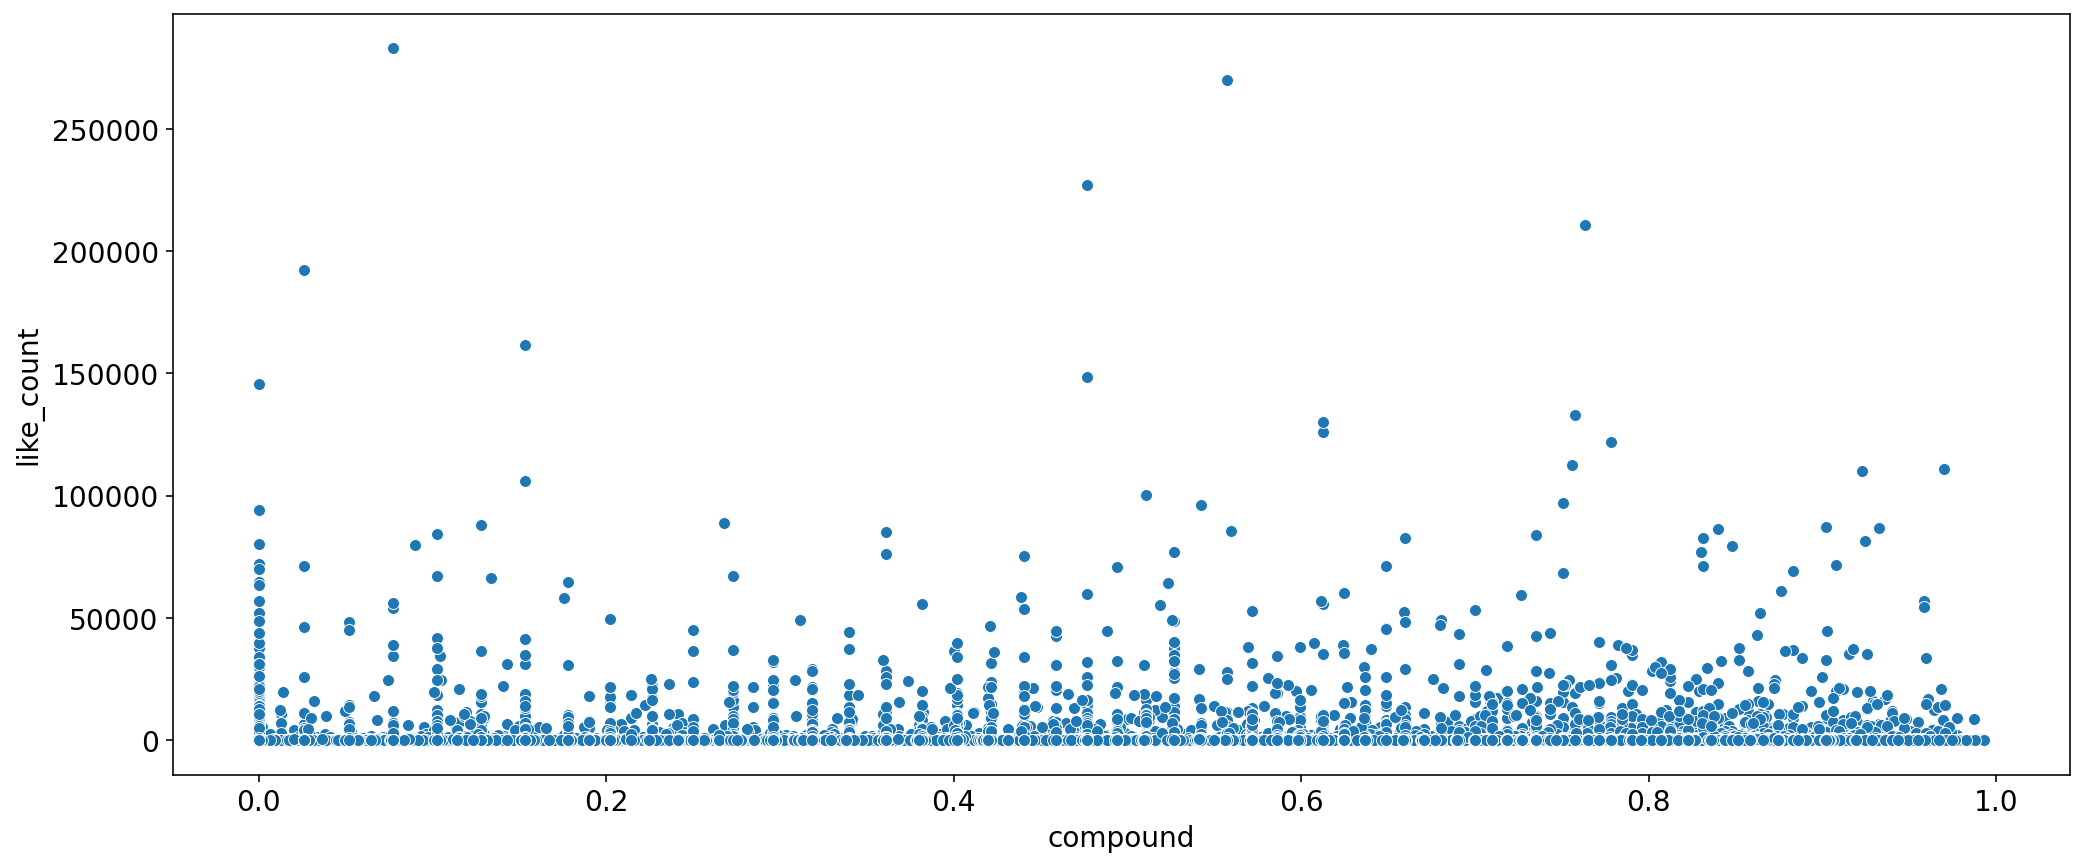

In [30]:
sns.scatterplot(data=df, x=np.abs(df['compound']), y='like_count')

Just from looking at the visualization it doesn't appear as though there is a strong positive linear relationship between the compound sentiment of a tweet and the number of likes it has. If we feel the visualization is misleading, we can refer to a numerical score. In this case that score would be Pearson's r; the linear correlation coefficient. If the absolute value of Pearson's r is high, then there is a strong relationship; the sign on the value tells us if the relationship is positive or negative.

In [37]:
r = np.corrcoef(df['like_count'], df['compound'])[0][1]
print(f'Our r is {r}')

Our r is -0.04234670845823782


And so it becomes clear, with our extremely small negatively valued r, that there isn't really a positive relationship between the number of likes and the sentiment. An argument could be made for removing those tweets that are outliers, that also doesn't make much sense; a relationship like this should especially hold in cases where there are tweets with a large number of likes. So sentiment appears to have no correlation with engagement, although a more robust statistical test could be conducted to make sure that this is the case. In any case, if there is one correlation that should exist, it is the correlation between sentiment and controversial topics. However, outside of tokenization, does Twitter have some way for us to glean insight into the topic of a tweet? The answer is yes: Hashtags. So what follows is an analysis on that front. In the below cell we generate a cleaned and tokenized list of hashtags, which we then value count to determine what the most popular topics in our dataset are:

In [55]:
hashes = (df[df['hashtags'] != '[]']['hashtags'] # Don't include tweets that have no hashtags
 .str.replace('[', '') 
 .str.replace(']', '') # Get rid of list brackets
 .str.split(',', expand=True) # Split and expand the resulting string before stacking all hashtags, and then canonizing
 .stack().str.strip().str.lower()).value_counts()

Below is a list of the 10 most popular hashtags in our dataset:

In [56]:
top10 = hashes[:11]
top10

'covid19'         378
'sotu'            331
'obamacare'       325
'aca'             264
'trumpcare'       241
'tcot'            230
'coronavirus'     216
'taxreform'       196
'goptaxscam'      194
'forthepeople'    181
'scotus'          168
dtype: int64

So every last one of these is a highly political topic in the United States. As such it would make sense for there to be a lot of sentiment surrounding these topics, and perhaps that sentiment can even be divided by party. In the following cell, we begin this analysis by getting all tweets with a hashtag related to COVID-19; the most popular hashtag in our dataset, and calculating their average absolute sentiment; we expect this number to be high:

In [48]:
np.abs(df[df['hashtags'].str.lower().str.contains('covid')]['compound']).mean()

0.45290677200902935

And indeed, this number is higher than the overall mean of compound sentiment for all tweets in our dataset. Thus we can move on to investigating how the sentiment breaks down by party:

<AxesSubplot:xlabel='party_name'>

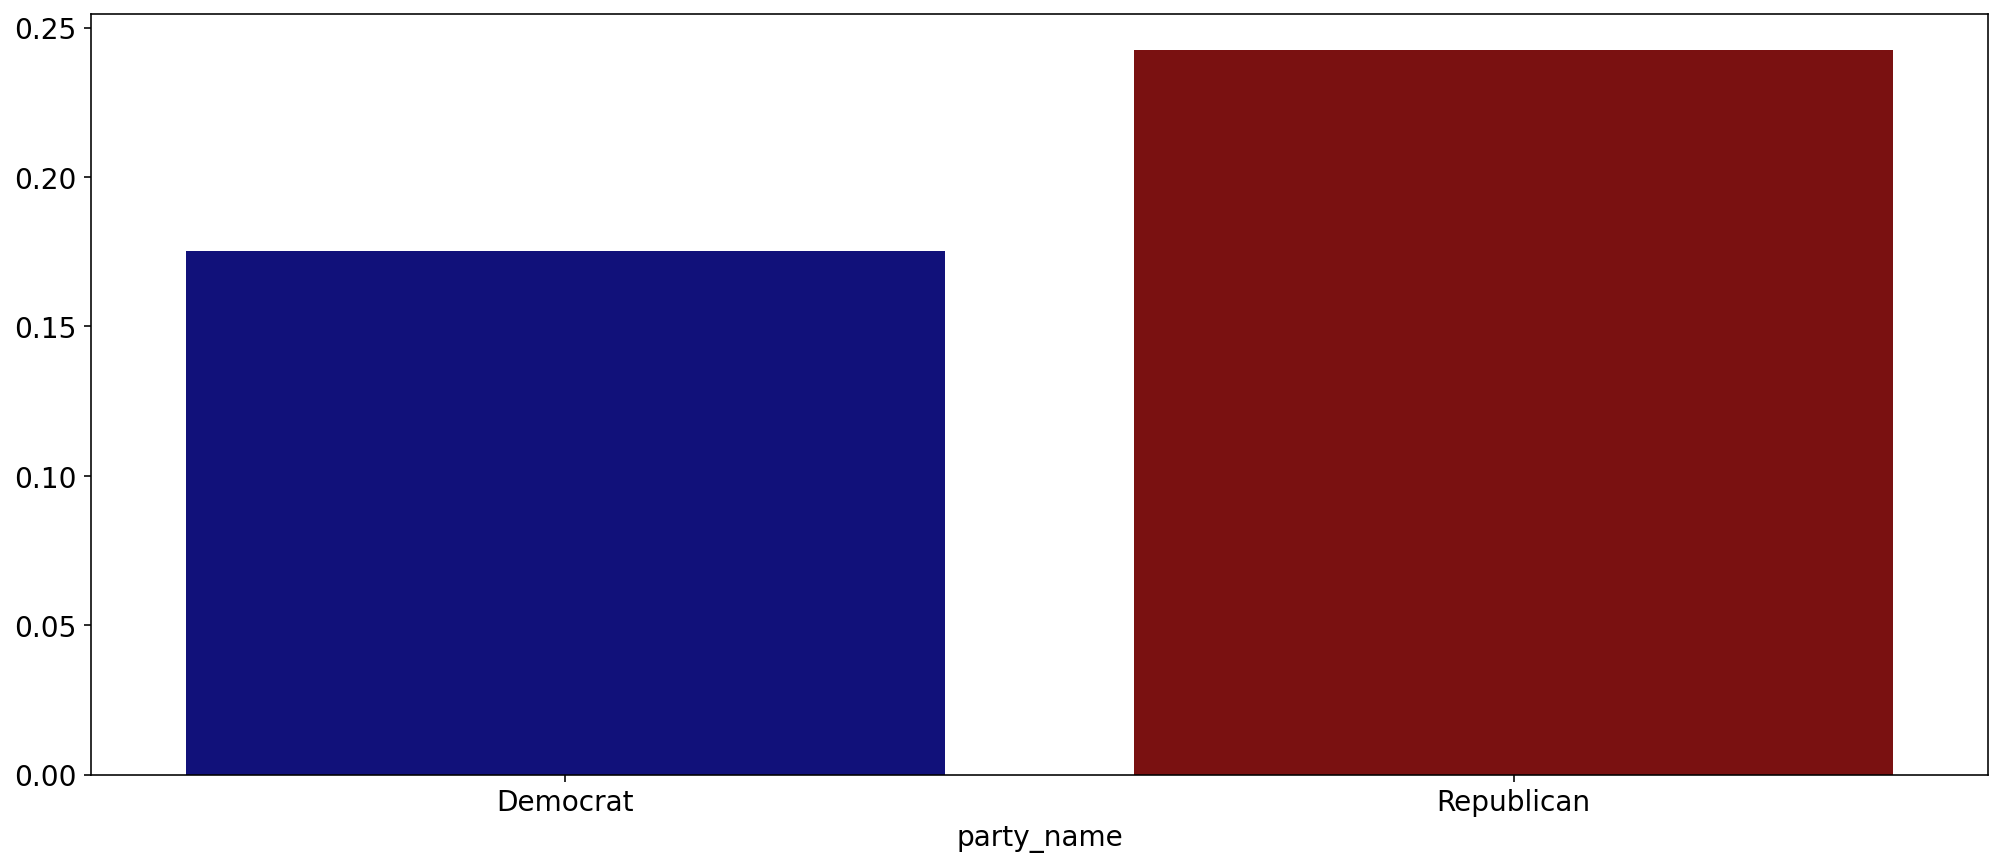

In [60]:
to_plot = df[df['hashtags'].str.lower().str.contains('covid')].groupby('party_name')['compound'].mean()
sns.barplot(x=to_plot.index, y=to_plot.values, palette=['darkblue', 'darkred'])

And in this case Democrats appear to, again, be more negative than Republicans but this time with respect to COVID-19. This line of investigation reveals that it might be a good idea to do some kind of investigation into the various topics in our dataset and see if there are clear differences in sentiment for the two major US political parties by topic. In other words it might give us insight into what motivates the difference in sentiment, if there is one.